# Introduction

This workbook is an introduction to the basic concepts and designs relating to the paper 

**Fast estimation of sparse quantum noise** by *Harper, Yu and Flammia*

This workbook is going to go through the basic ideas behind experimental design for a trivial 3 qubit system, using qiskit to simulate it. It shows how to build the local circuits in qasm.

This is only 3 qubits, to keep the simulation time nice and short. Of course 3 qubits is way too small for this system to be any use. We are looking at recovering Paulis in the order of $4^{\delta n}$, and $\delta$ is about 0.25 (upto a maximum of, say, 0.5). Here with n = 3, thats only about 4 values! We do in fact recover more, (about 10) but the high weight Paulis are 4*3 = 12, so really you wouldn't use this protocol here (In fact the number of experiments we do you could almsot certainly use a more tomography style to recover the 64 actual Paulis.



# Software needed 

For this introductory notebook, we need minimal software. All these packages should be available through the Julia package manager. However, we will need some to help with the simulation etc.

If you get an error trying to "use" them the error message tells you how to load them.

In [1]:
using Hadamard
using PyPlot
# convenience (type /otimes<tab>) - <tab> is the "tab" key.
⊗ = kron
# type /oplus<tab>
⊕ = (x,y)->mod.(x+y,2)


#3 (generic function with 1 method)

In [2]:
# I love this add on, especially as some of the simulations take a noticeable time. 
using ProgressMeter

In [3]:
# We are going to need some more of my code
# You can get it by doing the following, in the main julia repl (hit ']' to get to the package manager)
# pkg> add https://github.com/rharper2/Juqst.jl

# Currently there is harmless warning re overloading Hadamard.


using Juqst

In [4]:
# This is the code in this github that implements the various peeling algorithms for us.
include("peel.jl")

Main.PEEL

In [5]:
using Main.PEEL

In [6]:
include("./localPeelFunctions.jl")

getStabilizerForExperiment (generic function with 1 method)

### FInally we are going to need qiskit

(Instructions to get under Julia)

Need to install Conda, PyCall using the julia package manager.

Easiest way is the repl (hit ], then add Conda, add PyCall)
or...

```
using Pkg
Pkg.add("Conda")
Pkg.add("PyCall")
```

then use Conda to install pip
```
using Conda
Conda.add("pip")
```

Once that is done, then we can use pip to install qiskit (in a place Julia can find it).


```
using PyCall
run(`$(PyCall.pyprogramname) -m pip install qiskit`)
```

Then we can use qiskit from Julia!

In [7]:
using PyCall
qiskit = pyimport("qiskit")

PyObject <module 'qiskit' from '/Users/robin/.julia/conda/3/lib/python3.7/site-packages/qiskit/__init__.py'>

# Some preliminary information.

## This is replicated from "Scalable Estimation - Basic Concepts"


# Set up some Pauli Errors to find

# Choose our sub-sampling matrices

One of the main ideas behind the papers is that we can use the protocols in [Efficient learning of quantum channels](https://arxiv.org/abs/1907.12976) and [Efficient learning of quantum noise](https://arxiv.org/abs/1907.13022) to learn the eigenvalues of an entire stabiliser group ($2^n$) entries at once to arbitrary precision. Whilst it might be quite difficult to learn the eigenvalues of an arbitrary group as this will require an arbitrary $n-$qubit Clifford gate (which can be a lot of primitive gates!) even today's noisy devices can quite easily create a 2-local Stabiliser group over $n-$ qubits. 



Finally we are simulating the recovery in a 6 qubit system. That means our bitstrings are 12 bits long. 

Our experiments will need two sub-sampling groups. The first subsampling group will be two of our potential MuBs (set out below) (selected randomly). The second subsampling group will have single MUBs (potentialSingles below) on the first and fourth qubit, and a potential (two qubit) MuB on qubits 2 and 3.

This maximises the seperation of Paulis using local stabiliser (two qubit) groups.

In [8]:
all2QlMuBs

5-element Array{Array{Array{Int64,1},1},1}:
 [[0, 0, 0, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 0]]
 [[0, 0, 0, 0], [1, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 1]]
 [[0, 0, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 1]]
 [[0, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 1, 0]]
 [[0, 0, 0, 0], [0, 0, 1, 1], [1, 1, 0, 0], [1, 1, 1, 1]]

In [9]:
(experiments,paulisAll,ds) = generateSensibleSubsamples([(2,1),(1,2)])
print("$experiments\n")
print("$paulisAll\n")

Any[Any[(2, 1), (1, 1)], Any[(1, 3), (2, 2)]]
Any[Any[[[0, 0, 0, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 0]], [[0, 0], [0, 1]]], Any[[[0, 0], [1, 1]], [[0, 0, 0, 0], [1, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 1]]]]


In [10]:
noOfQubits = 3


3

In [11]:
# Here there are two sets of experiments
# The tuple for each qubit, is the (number, experiment type), 
# the numbers for each will add up to 4 (since we have 4 qubits)
experiments[1]

2-element Array{Any,1}:
 (2, 1)
 (1, 1)

# The Experiments

## So what are these experiments?


Let's pull in the figure from the paper which shows all the experimental designs:

![diagram showing designs](./figures/PhaseOffset.pdf)

Okay that's a bit busy, lets break it down.

Step 1 was to choose one MUB from the set for each pair of qubits, well that is what we did in PaulisAll, lets look at the first element of that

In [12]:
paulisAll[1]

2-element Array{Any,1}:
 [[0, 0, 0, 0], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 0]]
 [[0, 0], [0, 1]]

So because it was randomly chosen, you will have to look at that and convince yourself that indeed that each of the two elements shown above are one of these four sets of MuBs.

So the first experiment (the top row of (2)) is just an experiment to extract those eigenvalues.

How do we do that?

Well we have the circuits we need in the appendix of the paper - they look like this:

![circuits](./figures/circuits.png)

Where what we are going to need on each two qubit pair is either (a) or (c), depending on the MUB randomly selected

## Setting up the circuits

For the two qubit expermeints, circuit 1 is (a) above and circuit (2) is (c) above.

Effectively we take an input state in the computational basis, apply these circuits, do a Pauli twirl of varing gates, reverse the circuit and measure in the computational basis.

Some code to set up the circuits on the ... err ... circuit


In [13]:
pX = [0 1;1 0]
pY = [0 -im;im 0]
pZ = [1 0;0 -1]
pI = [1 0;0 1]
paulis = [pI,pX,pY,pZ]
superPaulis = [makeSuper(x) for x in paulis];


In [14]:
experiments[1]
numberOfQubits = foldl((a,b)->a[1]+b[1],experiments[1])

3

In [15]:
# Sanity check on noisless sim
circuit = getCircuit(experiments[1],12)
qiskit.execute(circuit,qiskit.Aer.get_backend("qasm_simulator"),shots=100).result().get_counts()

Dict{Any,Any} with 1 entry:
  "000" => 100

In [16]:
circuit.draw()

PyObject      ┌───┐     ┌───┐┌───┐┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐»
q_0: ┤ H ├─────┤ X ├┤ S ├┤ X ├─░─┤ Z ├─░─┤ Y ├─░─┤ X ├─░─┤ X ├─░─┤ X ├─░─┤ X ├»
     ├───┤┌───┐└─┬─┘└───┘└─┬─┘ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤»
q_1: ┤ H ├┤ S ├──■─────────■───░─┤ Z ├─░─┤ I ├─░─┤ Y ├─░─┤ Y ├─░─┤ Y ├─░─┤ Z ├»
     ├───┤└───┘                ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤»
q_2: ┤ H ├─────────────────────░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ Y ├─░─┤ I ├»
     └───┘                     ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘»
c_0: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_1: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
c_2: ═════════════════════════════════════════════════════════════════════════»
                                                                              »
«      ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐┌───┐»
«q_0: ─░─┤ I ├─░─┤ Z ├─░─┤ Y ├─░─┤ X ├─░─┤ I ├─░─┤ Y ├─░─┤ Z ├─░─┤ X ├┤ S ├»
«      ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ └─┬─┘└───┘»
«q_1: ─░─┤ Y ├─░─┤ Y ├─░─┤ X ├─░─┤ Y ├─░─┤ Z ├─░─┤ I ├─░─┤ Y ├─░───■───────»
«      ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ ├───┤ ░ ┌───┐     »
«q_2: ─░─┤ Y ├─░─┤ Y ├─░─┤ X ├─░─┤ Z ├─░─┤ I ├─░─┤ Z ├─░─┤ Z ├─░─┤ H ├─────»
«      ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘     »
«c_0: ═════════════════════════════════════════════════════════════════════»
«                                                                          »
«c_1: ═════════════════════════════════════════════════════════════════════»
«                                                                          »
«c_2: ═════════════════════════════════════════════════════════════════════»
«                                                                          »
«     ┌───┐┌───┐┌───┐┌───┐                ░ ┌─┐      
«q_0: ┤ S ├┤ S ├┤ X ├┤ H ├────────────────░─┤M├──────
«     └───┘└───┘└─┬─┘├───┤┌───┐┌───┐┌───┐ ░ └╥┘┌─┐   
«q_1: ────────────■──┤ S ├┤ S ├┤ S ├┤ H ├─░──╫─┤M├───
«                    └───┘└───┘└───┘└───┘ ░  ║ └╥┘┌─┐
«q_2: ────────────────────────────────────░──╫──╫─┤M├
«                                         ░  ║  ║ └╥┘
«c_0: ═══════════════════════════════════════╩══╬══╬═
«                                               ║  ║ 
«c_1: ══════════════════════════════════════════╩══╬═
«                                                  ║ 
«c_2: ═════════════════════════════════════════════╩═
«

In [17]:
# Creates a primitive noise ansatz
""" get_noise - get a primitive noise model reflecting the passed in parameters
    
    Parameters:
    - p_meas: the probability of measurement error.
    - p_gate: the probability of a single qubit gate error.
    - p_gate2: the probability of a cx/cz error
    
    Returns: the noise_model.
"""
function get_noise(p_meas,p_gate,p_gate2)
    error_meas =  qiskit.providers.aer.noise.errors.pauli_error([("X",p_meas), ("I", 1 - p_meas)])
    error_gate1 = qiskit.providers.aer.noise.errors.depolarizing_error(p_gate, 1)
    error_gate2 = qiskit.providers.aer.noise.errors.depolarizing_error(p_gate2,2)

    noise_model = qiskit.providers.aer.noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x","h","s","z","u3","id"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
    return noise_model
end
noise_model = get_noise(0.02,0.01,0.015)# from qiskit.providers.aer.noise import NoiseModel   

PyObject NoiseModel:
  Basis gates: ['cx', 'h', 'id', 's', 'u3', 'x', 'z']
  Instructions with noise: ['measure', 'z', 'u3', 'x', 's', 'h', 'cx', 'id']
  All-qubits errors: ['measure', 'x', 'h', 's', 'z', 'u3', 'id', 'cx']

In [53]:
lengths=[2,4,10,20,60,100,200]
@time res = doASeries(experiments[1],lengths,50,2000,noise_model)
cc = getCounts(res,lengths,noOfQubits)
eigs = extractEigenvalues(cc,lengths)

164.563599 seconds (1.24 M allocations: 60.870 MiB, 0.02% gc time)


8-element Array{Float64,1}:
 1.0
 0.984947034991551
 0.984992079684527
 0.9850246586649374
 0.9925184142317649
 0.9773391793642305
 0.9778266894559563
 0.9776545742280393

In [61]:
indices = generateEigenvalues(getStabilizerForExperiment(experiments[1]))
for (ix,e) in enumerate(eigs)
    print("$(PEEL.fidelityLabels(indices[ix]-1,qubits=3)): $e\n")
end

III: 1.0
IZX: 0.984947034991551
IYZ: 0.984992079684527
IXY: 0.9850246586649374
XII: 0.9925184142317649
XZX: 0.9773391793642305
XYZ: 0.9778266894559563
XXY: 0.9776545742280393


In [75]:
recoveredEigenvalues = Dict()
indices = generateEigenvalues(getStabilizerForExperiment(experiments[1]))
for i in 1:2^noOfQubits
    recoveredEigenvalues[indices[i]] = push!(get(recoveredEigenvalues,indices[i],[]),eigs[i])
end

### Note

In the graph below, we can see the primitive noise model we employ. All multi qubit Paulis have the same eigenvalues (also known as fidelity). We get distinct bands depending on whether we have one, two or three Paulis. In reality the device would not have this clear distinction.

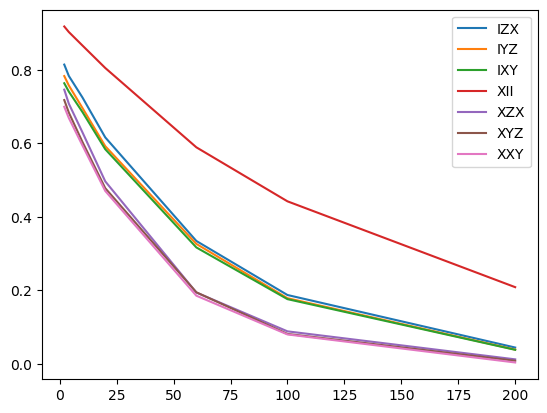

PyObject <matplotlib.legend.Legend object at 0x7fc353b8a290>

In [76]:
experiment1_SpamyEigenvalues = map(ifwht_natural,cc);
# Dont bother with the first element as its all 1.
for x = 2:2^noOfQubits
    toPlot = [d[x] for d in experiment1_SpamyEigenvalues]
    plot(lengths,toPlot,label=PEEL.fidelityLabels(indices[x]-1,qubits=3))
end
legend()

In [77]:
recoveredEigenvalues

Dict{Any,Any} with 8 entries:
  7  => Any[0.985025]
  30 => Any[0.977339]
  14 => Any[0.984947]
  23 => Any[0.977655]
  28 => Any[0.977827]
  17 => Any[0.992518]
  12 => Any[0.984992]
  1  => Any[1.0]

In [78]:
experiments[2]

2-element Array{Any,1}:
 (1, 3)
 (2, 2)

In [79]:
# Cycle through experiments... to generate offsets.
shots = 2000
sequences = 40
experi = experiments[1]
# This is step 2 of the figure - we move through the different qubit groups.
@showprogress 1 "QubitGroups" for (ix,stabilizerSelect) in enumerate(experi)
    # If it is two qubits we have 5 stabilizer experiments/circuits
    range = 1:5
    if stabilizerSelect[1] == 1 # one qubit only so only 3 stabiliser experiments
        range = 1:3
    end
    @showprogress 1 "Experiment:  " for experimentType in range
        newStab = stabilizerSelect
        # Check if we have already done this one.
        if newStab[2] != experimentType # New experiment needed.
            experimentToDo = copy(experi)
            newStab = (newStab[1],experimentType)
            experimentToDo[ix]=newStab
            # Work out the Paulis for that experiment type (we need this later)
            paulisForExperiment = getStabilizerForExperiment(experimentToDo)
            # Run the experiment for the requisite sequences and shots.
            results = doASeries(experimentToDo,lengths,sequences,shots,noise_model)
            # Extract the estimated eigenvalues (2^noOfQubits)
            cc = getCounts(results,lengths,noOfQubits)
            eigs = extractEigenvalues(cc,lengths)
            # Work out what eigenvalues we have calcuated
            indices = generateEigenvalues(paulisForExperiment)
            #print("We have experiment $experimentToDo\nWIth indices $indices\n")
            # Put them into our 'recoveredEigenvalue' oracle.
            for i in 1:2^noOfQubits
                recoveredEigenvalues[indices[i]] = push!(get(recoveredEigenvalues,indices[i],[]),eigs[i])
            end
        end
    end

end


Experiment:  100%|██████████████████████████████████████| Time: 0:18:41
Experiment:  100%|██████████████████████████████████████| Time: 0:07:04
QubitGroups100%|████████████████████████████████████████| Time: 0:25:45


In [80]:
for k in sort(collect(keys(recoveredEigenvalues)))
    print("$(PEEL.fidelityLabels(k-1,qubits=3)):   $(round.(recoveredEigenvalues[k],digits=5))\n")
end


III:   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
IIX:   [0.99253]
IIY:   [0.99255]
IIZ:   [0.99244]
IXI:   [0.99255]
IXX:   [0.98528]
IXY:   [0.98502, 0.98494, 0.98494]
IXZ:   [0.98493]
IYI:   [0.99251]
IYX:   [0.98486]
IYY:   [0.98523]
IYZ:   [0.98499, 0.98479, 0.98478]
IZI:   [0.9925]
IZX:   [0.98495, 0.98503, 0.98517]
IZY:   [0.98486]
IZZ:   [0.985]
XII:   [0.99252, 0.99251, 0.99248, 0.99244, 0.99249]
XIX:   [0.98513]
XIY:   [0.9852]
XIZ:   [0.98482]
XXI:   [0.98522]
XXX:   [0.97793]
XXY:   [0.97765]
XXZ:   [0.97747]
XYI:   [0.98511]
XYX:   [0.97749]
XYY:   [0.97765]
XYZ:   [0.97783]
XZI:   [0.98518]
XZX:   [0.97734]
XZY:   [0.97761]
XZZ:   [0.97746]
YII:   [0.99259]
YXY:   [0.97729]
YYZ:   [0.97708]
YZX:   [0.97785]
ZII:   [0.99251]
ZXY:   [0.97712]
ZYZ:   [0.97707]
ZZX:   [0.97762]


In [81]:
experiments

2-element Array{Any,1}:
 Any[(2, 1), (1, 1)]
 Any[(1, 3), (2, 2)]

In [82]:
# Now we need to repeat, but this time for experiment 2
res2 = doASeries(experiments[2],lengths,sequences,shots,noise_model)
cc2 = getCounts(res2,lengths,noOfQubits)
eigs2 = extractEigenvalues(cc2,lengths)
indices2 = generateEigenvalues(getStabilizerForExperiment(experiments[2]))
print("$indices2\n")
for i in 1:2^noOfQubits
    recoveredEigenvalues[indices2[i]] = push!(get(recoveredEigenvalues,indices2[i],[]),eigs2[i])
end

[1, 4, 57, 60, 29, 32, 37, 40]


In [83]:
for k in sort(collect(keys(recoveredEigenvalues)))
    print("$(PEEL.fidelityLabels(k-1,qubits=3)):   $(round.(recoveredEigenvalues[k],digits=5))\n")
end


III:   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
IIX:   [0.99253]
IIY:   [0.99255]
IIZ:   [0.99244, 0.9925]
IXI:   [0.99255]
IXX:   [0.98528]
IXY:   [0.98502, 0.98494, 0.98494]
IXZ:   [0.98493]
IYI:   [0.99251]
IYX:   [0.98486]
IYY:   [0.98523]
IYZ:   [0.98499, 0.98479, 0.98478]
IZI:   [0.9925]
IZX:   [0.98495, 0.98503, 0.98517]
IZY:   [0.98486]
IZZ:   [0.985]
XII:   [0.99252, 0.99251, 0.99248, 0.99244, 0.99249]
XIX:   [0.98513]
XIY:   [0.9852]
XIZ:   [0.98482]
XXI:   [0.98522]
XXX:   [0.97793]
XXY:   [0.97765]
XXZ:   [0.97747]
XYI:   [0.98511]
XYX:   [0.97749]
XYY:   [0.97765]
XYZ:   [0.97783]
XZI:   [0.98518, 0.98508]
XZX:   [0.97734]
XZY:   [0.97761]
XZZ:   [0.97746, 0.97787]
YII:   [0.99259]
YXI:   [0.98488]
YXY:   [0.97729]
YXZ:   [0.97758]
YYZ:   [0.97708]
YZX:   [0.97785]
ZII:   [0.99251]
ZXY:   [0.97712]
ZYI:   [0.98506]
ZYZ:   [0.97707, 0.97794]
ZZX:   [0.97762]


In [84]:
# And then cycle through experiments for experiments[2] ... to generate offsets.

experi = experiments[2]
# This is step 2 of the figure - we move through the different qubit groups.
@showprogress 1 "QubitGroups" for (ix,stabilizerSelect) in enumerate(experi)
    # If it is two qubits we have 5 stabilizer experiments/circuits
    range = 1:5
    if stabilizerSelect[1] == 1 # one qubit only so only 3 stabiliser experiments
        range = 1:3
    end
    @showprogress 1 "Experiment:  " for experimentType in range
        newStab = stabilizerSelect
        # Check if we have already done this one.
        if newStab[2] != experimentType # New experiment needed.
            experimentToDo = copy(experi)
            newStab = (newStab[1],experimentType)
            experimentToDo[ix]=newStab
            # Work out the Paulis for that experiment type (we need this later)
            paulisForExperiment = getStabilizerForExperiment(experimentToDo)
            # Run the experiment for the requisite sequences and shots.
            results = doASeries(experimentToDo,lengths,sequences,shots,noise_model)
            # Extract the estimated eigenvalues (2^noOfQubits)
            cc = getCounts(results,lengths,noOfQubits)
            eigs = extractEigenvalues(cc,lengths)
            # Work out what eigenvalues we have calcuated
            indices = generateEigenvalues(paulisForExperiment)
            # print("We have experiment $experimentToDo\nWIth indices $indices\n")
            # Put them into our 'recoveredEigenvalue' oracle.
            for i in 1:2^noOfQubits
                recoveredEigenvalues[indices[i]] = push!(get(recoveredEigenvalues,indices[i],[]),eigs[i])
            end
        end
    end

end


Experiment:  100%|██████████████████████████████████████| Time: 0:07:17
Experiment:  100%|██████████████████████████████████████| Time: 0:13:15
QubitGroups100%|████████████████████████████████████████| Time: 0:20:33


In [87]:
for k in sort(collect(keys(recoveredEigenvalues)))
    print("$(PEEL.fidelityLabels(k-1,qubits=3)):   $(round.(recoveredEigenvalues[k],digits=5))\n")
end


III:   [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
IIX:   [0.99253, 0.99255]
IIY:   [0.99255, 0.99239]
IIZ:   [0.99244, 0.9925, 0.99242, 0.99248, 0.9924, 0.99258]
IXI:   [0.99255, 0.9926]
IXX:   [0.98528]
IXY:   [0.98502, 0.98494, 0.98494]
IXZ:   [0.98493, 0.98519]
IYI:   [0.99251, 0.99238]
IYX:   [0.98486]
IYY:   [0.98523]
IYZ:   [0.98499, 0.98479, 0.98478, 0.98478]
IZI:   [0.9925, 0.99235]
IZX:   [0.98495, 0.98503, 0.98517]
IZY:   [0.98486]
IZZ:   [0.985, 0.98502]
XII:   [0.99252, 0.99251, 0.99248, 0.99244, 0.99249, 0.99242]
XIX:   [0.98513]
XIY:   [0.9852]
XIZ:   [0.98482, 0.98509]
XXI:   [0.98522, 0.98515]
XXX:   [0.97793]
XXY:   [0.97765]
XXZ:   [0.97747, 0.97785]
XYI:   [0.98511, 0.98504]
XYX:   [0.97749]
XYY:   [0.97765]
XYZ:   [0.97783, 0.97762]
XZI:   [0.98518, 0.98508, 0.98479, 0.98481]
XZX:   [0.97734, 0.97763]
XZY:   [0.97761, 0.97769]
XZZ:   [0.97746, 0.97787]
YII:   [0.99259, 0.99242]
YIZ:   [0.98471]
YXI:   [0.98488, 0.98508, 0.98496]
YXX:   [0

In [88]:
using Statistics
fids= Float64[]
# Compared to the total number of Eigenvalues, which is
for i in sort(collect(keys(recoveredEigenvalues)))
    print("$(PEEL.fidelityLabels(i-1,qubits=3)) $(round(mean(recoveredEigenvalues[i]),digits=4))\n")
    push!(fids,round(mean(recoveredEigenvalues[i]),digits=4))
end

III 1.0
IIX 0.9925
IIY 0.9925
IIZ 0.9925
IXI 0.9926
IXX 0.9853
IXY 0.985
IXZ 0.9851
IYI 0.9924
IYX 0.9849
IYY 0.9852
IYZ 0.9848
IZI 0.9924
IZX 0.985
IZY 0.9849
IZZ 0.985
XII 0.9925
XIX 0.9851
XIY 0.9852
XIZ 0.985
XXI 0.9852
XXX 0.9779
XXY 0.9777
XXZ 0.9777
XYI 0.9851
XYX 0.9775
XYY 0.9777
XYZ 0.9777
XZI 0.985
XZX 0.9775
XZY 0.9777
XZZ 0.9777
YII 0.9925
YIZ 0.9847
YXI 0.985
YXX 0.9776
YXY 0.9775
YXZ 0.9776
YYI 0.9849
YYZ 0.9771
YZI 0.9851
YZX 0.9778
YZZ 0.9775
ZII 0.9924
ZIZ 0.985
ZXI 0.9849
ZXY 0.9771
ZXZ 0.9774
ZYI 0.9849
ZYX 0.9777
ZYY 0.9774
ZYZ 0.9775
ZZI 0.9848
ZZX 0.9776
ZZZ 0.9775


In [90]:
# Average them out
using Statistics
oracleToUse = Dict()
for k in keys(recoveredEigenvalues)
    oracleToUse[k]=mean(recoveredEigenvalues[k])
end

In [91]:
# Generate the samples directly
samples = []
for (ix,x) in enumerate(paulisAll)
    # Similarly if we reverse above (right hand least significant, then we reverse here)
   push!(samples,[[y for y in generateFromPVecSamples4N(reverse(x),d)] for d in ds])
end


In [92]:
listOfX = [[fwht_natural([oracleToUse[x+1] for x in y]) for y in s] for s in samples];


In [93]:
# Some functions to give us labels:
function probabilityLabels(x;qubits=2)
    str = string(x,base=4,pad=qubits)
    paulis = ['I','Y','X','Z']
    return map(x->paulis[parse(Int,x)+1],str)
end

function fidelityLabels(x;qubits=2)
    str = string(x,base=4,pad=qubits)
    paulis = ['I','X','Y','Z']
    return map(x->paulis[parse(Int,x)+1],str)
end


fidelityLabels (generic function with 1 method)

In [94]:
# Use the patterns to create the listOfPs

# What is this?? Well basically it tells us which Pauli error fell into which bin, given our choice of experiment
# So the first vector (listOfPs[1][1])
listOfPs=[]
for p in paulisAll
    hMap = []
    # Because here we use right hand least significant - we just reverse the order we stored the experiments.
    for i in reverse(p)
       #print("Length $(length(i))\n")
       if length(i) == 2
            push!(hMap,twoPattern(i))
        elseif length(i) == 4
            push!(hMap,fourPattern([i])[1])
        else # Assume a binary bit pattern
            push!(hMap,[length(i)])
        end
    end
    push!(listOfPs,hMap)
end
listOfPs

2-element Array{Any,1}:
 Any[[["00", "01"], ["10", "11"]], [["0000", "1110", "1001", "0111"], ["1100", "0010", "0101", "1011"], ["0100", "1010", "1101", "0011"], ["1000", "0110", "0001", "1111"]]]
 Any[[["0000", "0110", "1101", "1011"], ["1100", "1010", "0001", "0111"], ["1000", "1110", "0101", "0011"], ["0100", "0010", "1001", "1111"]], [["00", "11"], ["10", "01"]]]

In [114]:
using LinearAlgebra
maxPass = 200
# singletons is when 'noise' threshold below which we declare we have found a singletons
# It will be related to the measurment accuracy and the number of bins
# Here we base it off the shotsToDo variance, on the basis of our hoped for recovery

# We start that one low and then slowly increase it, meaning we are more likely to accept
# If you have a certain probability distribution and this ansatz is not working, set it
# so that you get a reasonable number of hits in the first round.
singletons = (0.002*.999)/30000
singletonsInc = singletons/2

# Zeros is set high - we don't want to accept bins with very low numbers as they are probably just noise
# If the (sum(mean - value)^2) for all the offsets is below this number we ignore it.
# But then we lower it, meaning we are less likely to think a bin has no value in it.
# Obviously it should never be negative.
zerosC = (0.03*.999)/20000*2*1.1
zerosDec = (zerosC*0.99)/maxPass
mappings=[]

prevFound = 0
qubitSize = 3

listOfX = [[fwht_natural([oracleToUse[x+1] for x in y]) for y in s] for s in samples]
found = Dict()
rmappings = []
for x in mappings
    if length(x) == 0
        push!(rmappings,x)
    else
        ralt = Dict()
        for i in keys(x)
            ralt[x[i]]= i
        end
        push!(rmappings,ralt)
    end
end    
prevFound = 0


for i in 1:maxPass



    for co = 1:length(listOfX)
        bucketSize = length(listOfX[co][1])
        for extractValue = 1:bucketSize
            extracted = [x[extractValue] for x in listOfX[co]]
            if !(PEEL.closeToZero(extracted,qubitSize*2,cutoff= zerosC))
               (isit,bits,val) = PEEL.checkAndExtractSingleton([extracted],qubitSize*2,cutoff=singletons)
               if isit
                  #print("$bits\n")
                  #pval = binaryArrayToNumber(j6*[x == '0' ?  0 : 1 for x in bits])
                  vval = parse(Int,bits,base=2)
                  #print("$bits, $vval $(round(dist[vval+1],digits=5)) and $(round(val,digits=5))\n")
                  PEEL.peelBack(listOfX,listOfPs,bits,val,found,ds,rmappings)
               end
            end
        end   
    end
    if length(found) > prevFound
                prevFound = length(found)
    else
        singletons += singletonsInc
        zerosC -=zerosDec 
        if (zerosC <= 0)
                break
        end
     end
     if length(found) > 0
                print("Pass $i, $(length(found)) $(sum([mean(found[x]) for x in keys(found)]))\n")
            if sum([mean(found[x]) for x in keys(found)]) >= 0.999995
                break
            end
     end


end

Pass 57, 1 0.0031676726573997005
Pass 58, 1 0.0031676726573997005
Pass 59, 1 0.0031676726573997005
Pass 60, 2 0.004486562148295693
Pass 61, 4 0.008377550994456414
Pass 62, 6 0.012182202530395264
Pass 63, 8 0.9971617291586665
Pass 64, 10 1.0008707051790193


In [115]:
for k in keys(found)
    print("$(probabilityLabels(parse(Int,k,base=2),qubits=3)) -- $(round.(found[k],digits=4))\n")
end

IIY -- [0.0021]
XII -- [0.0019]
IXI -- [0.0013]
IIX -- [0.0018]
III -- [0.9831]
IIZ -- [0.0018]
IZI -- [0.0019]
YII -- [0.0032]
IYI -- [0.0018]
ZII -- [0.0019]


## And that's all folks

What do we see, well we recovered 10 values, which is more than advertised. They were all single Pauli errors, and whilst there is some variation - they are all in the right ballpark. 40 seqeunces of 2,000 shots is a relatively small number ot recover to this precision - it only gets better with more qubits and more sequences.
    